# Run ModelEvaluations 
This file is outputs the actual model performance charts over periods and produce all data necessary 
for the Website to pick up. It reads data from s3 for all our ratio and price information as well as
the model outputs from our training runs. Then it runs the models for each period and picks the highest
performing stocks from each of the models.

It is super important that we do not leak data into the future to bias results of the model, so there
is extraordinary care that is taken to produced results that do not "look" into the future.

Three things are accomplished in this file:
1. Gather training data output and (models and other training output) and use that to output the SHAP values for each model as well as any charts.
2. Generate stock picks for each of the model periods and save those away.
3. Chart and calculate performance of the model over the periods that models have been built.


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import softmax

from sklearn.metrics import roc_auc_score
import shap

import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import s3finance as s3c
from labellines import labelLines
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from functools import partialmethod
from matplotlib import pyplot as plt, dates
from sklearn.metrics import confusion_matrix, auc, roc_curve
from statistics import mean
import pandas_market_calendars as mcal
import matplotlib.dates as mdates
from matplotlib import gridspec
import seaborn as sns
import joblib
from io import BytesIO

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

In [3]:
# set up access to access class
#
AWS_BUCKET = "w210-wrds-data"
OUTPUT_DATA = False
#importlib.reload(s3c)
#version='1658006391.481648'
#version='1658902110.776109'
version='1659216789.930134'
s3f = s3c.s3finance(AWS_BUCKET,version=version)

In [4]:
%%time
#
# Read all Price Data
#
# get all the financial ratios
all_ratios = s3f.getsummaryallratiopricesfinancial()

CPU times: user 5.06 s, sys: 3.51 s, total: 8.58 s
Wall time: 22.5 s


In [5]:
%%time
# get all the stock prices
all_prices = s3f.getsummaryprices()
#all_prices = None

CPU times: user 36.9 s, sys: 22.6 s, total: 59.4 s
Wall time: 1min 12s


In [6]:
# get SPY prices
#version='1658134425.075057'
#version='1658902110.776109'
version = '1659216789.930134'
s3f = s3c.s3finance(AWS_BUCKET,version=version)
spyprices=s3f.getstockprices("SPY")

In [7]:
#importlib.reload(s3c)
# version='1658902110.776109'
# s3f = s3c.s3finance(AWS_BUCKET,version=version)
#version='1658006391.481648'
#s3f = s3c.s3finance(AWS_BUCKET)

## Set up Model to pull out of S3 after training.

In [8]:
%%time
#modelname = 'model-period-3-year-84-cycles'
#modelname = 'model-period-5-year-72-cycles'
#modelname = 'model-period-7-year-60-cycles'
#modelname = 'model-period-10-year-120-cycles'
#modelname = 'model-period-10-year-132-cycles-1658902110.776109'
modelname = 'model-period-10-year-214-cycles-1659216789.930134-full'
#modelname = 'model-period-10-year-12-cycles-1659216789.930134'
#modelname = 'model-period-10-year-12-cycles-1659216789.930134-f1'
#modelname = 'model-period-10-year-60-cycles-1659216789.930134-f1'
#modelname = 'model-period-10-year-12-cycles-1659216789.930134-accuracy-full'
#model-period-10-year-12-cycles-1659216789.930134-f1
# load the model from diskr
results,shaplist,loaded_models = s3f.getmodeldata(modelname+'.pkl')


CPU times: user 24.8 s, sys: 8.93 s, total: 33.7 s
Wall time: 15.1 s


In [9]:
# set up nyse calendar
nyse = mcal.get_calendar('NYSE')

### Output the feature importance using SHAP values in this section

In [10]:
def get_feature_importances_shap_values(shap_values_list, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    feature_importances_list = []
    feature_importances_norm_list = []
    for shap_values in shap_values_list:
        importances = []
        for i in range(shap_values.values.shape[1]):
            #importances.append(np.mean(np.abs(shap_values.values[:, i])))
            importances.append(np.mean(shap_values.values[:, i]))
        # Calculates the normalized version
        importances_norm = softmax(importances)
        # Organize the importances and columns in a dictionary
        #print(len(importances),len(features))
        feature_importances = {fea: imp for imp, fea in zip(importances, features)}
        feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
        # Sorts the dictionary
        feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
        feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
        feature_importances_list.append(feature_importances)
        feature_importances_norm_list.append(feature_importances_norm)
    
    return feature_importances_list,feature_importances_norm_list

In [11]:
fil,fin = get_feature_importances_shap_values(shaplist, list(results.drop(columns=['date','score']).columns))

In [12]:
#fin

In [13]:
f = pd.DataFrame(data=fil, columns= list(results.drop(columns=['date','score']).columns))

In [14]:
f['datadate'] = results['date']
f = f.set_index('datadate')

In [15]:
# write out explainability data
if OUTPUT_DATA:
    f = s3f.putmodelexplainability(f,modelname)

In [45]:
f = s3f.putmodelexplainability(f,modelname)

In [44]:
f

,cash_conversion,gpm,invt_act,stko,intcov_ratio,pretret_noa,sale_equity,lt_ppent,rect_turn,sale_nwc,...,ggroup,rd_sale,gsubind,gprof,pe_inc,capei,at_turn,eps,spcindcd,cik
datadate,,,,,,,,,,,,,,,,,,,,,
2004-02-01,0.000228,-0.004300,-0.002172,0.002024,0.003028,0.002592,0.000828,-0.003560,-0.006592,-0.004980,...,0.000688,0.000000,-0.000940,-0.001380,-0.003052,-0.002456,-0.000812,-0.003556,-0.001672,0.001084
2004-03-01,-0.000072,-0.004556,0.001492,-0.000904,-0.000088,0.001032,-0.000468,0.001100,-0.003128,0.001920,...,-0.003168,-0.001204,0.005556,0.001832,-0.003460,-0.001344,0.000152,-0.005404,-0.003172,0.007792
2004-04-01,-0.000632,0.000000,0.000536,0.000868,-0.000604,0.000008,0.002656,-0.004492,-0.007796,0.001560,...,-0.002752,0.002736,-0.007184,-0.001864,0.002252,-0.007920,-0.010760,-0.011028,-0.004088,0.003008
2004-05-01,-0.000044,-0.002628,-0.001056,0.000444,-0.000692,0.001428,-0.000628,0.005020,-0.005524,-0.002360,...,-0.004592,0.007760,0.001596,-0.001148,0.000884,-0.001988,0.001668,-0.005564,0.004444,0.002264
2004-06-01,-0.003440,-0.007016,0.001208,0.001724,-0.001032,0.000624,0.001044,-0.001660,-0.004048,-0.002420,...,-0.005628,0.001612,-0.002056,0.001232,0.001520,-0.002840,-0.002172,-0.004712,-0.001056,0.000356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,0.000148,-0.002232,0.001704,-0.000044,0.002820,0.001424,0.002636,-0.001308,0.002332,-0.000540,...,0.002464,0.005952,0.004924,0.007556,0.000352,0.000068,0.002132,-0.000408,-0.000684,0.000908
2021-08-01,-0.000836,-0.001024,0.000016,-0.000112,-0.003732,-0.000936,0.001352,-0.000980,-0.004280,-0.000684,...,0.003692,0.010392,0.000832,-0.005928,0.000592,0.003932,-0.000028,0.003444,-0.000772,0.001340
2021-09-01,-0.001548,-0.004228,-0.000272,0.000024,-0.000552,-0.001592,0.001664,-0.003136,-0.001172,-0.003512,...,0.000956,0.044040,0.002436,-0.004752,0.001616,-0.000944,0.001592,0.000548,0.000332,-0.003816


In [17]:
%%capture
# examples stock explainability
#f1 = f.subtract(f.min(axis=1),axis=0).div(f.max(axis=1) - f.min(axis=1),axis=0)
f.subtract(f.min(axis=1),axis=0).div(f.max(axis=1) - f.min(axis=1),axis=0).iloc[0].sort_values(ascending=False,key=abs)

In [18]:
%%capture
# examples stock explainability
#f1 = f.div(f.sum(axis=1),axis=0)#.iloc[6].sort_values(ascending=False)
f.iloc[0].sort_values(ascending=False,key=abs)#*100

In [33]:
#f1.iloc[1].sort_values(ascending=False)
f = s3f.getmodelexplainability(modelname)
f.columns

Index(['cash_conversion', 'gpm', 'invt_act', 'stko', 'intcov_ratio',
       'pretret_noa', 'sale_equity', 'lt_ppent', 'rect_turn', 'sale_nwc',
       'peg_trailing', 'sic', 'evm', 'debt_ebitda', 'roa', 'ocf_lct', 'efftax',
       'profit_lct', 'rect_act', 'dpr', 'roce', 'pay_turn', 'volatility',
       'peg_ltgforward', 'debt_at', 'debt_assets', 'inv_turn',
       'totdebt_invcap', 'pe_op_basic', 'pe_op_dil', 'naics', 'divyield',
       'fcf_ocf', 'pe_exi', 'pretret_earnat', 'cash_debt', 'de_ratio', 'cshoc',
       'adjusted_price', 'ggroup', 'rd_sale', 'gsubind', 'gprof', 'pe_inc',
       'capei', 'at_turn', 'eps', 'spcindcd', 'cik'],
      dtype='object')

In [36]:
%%capture
explainability = results.dropna().drop(columns=['date']).abs().mean().\
sort_values(ascending=False).to_frame().reset_index().rename(columns={'index': 'feature',0:'value_score'})
e= explainability.iloc[1:].copy()
e['scaled'] = (\
    e['value_score'] - \
    e['value_score'].min()) / \
    (e['value_score'].max() - e['value_score'].min())

e

In [43]:
# write out combined model data for average and very month
if OUTPUT_DATA:
    ef = s3f.putmodelexplainability(e,modelname+'-average')
print(modelname+'-average')
ef

model-period-10-year-214-cycles-1659216789.930134-full-average


,feature,value_score,scaled
1,adjusted_price,0.088752,1.000000
2,pe_op_basic,0.055019,0.595325
3,rd_sale,0.034668,0.351197
4,pe_op_dil,0.029533,0.289590
5,gsubind,0.029299,0.286787
6,ggroup,0.026425,0.252312
7,fcf_ocf,0.025285,0.238634
8,pe_exi,0.022860,0.209541
9,volatility,0.020192,0.177532
10,cik,0.019467,0.168844


<AxesSubplot:ylabel='feature'>

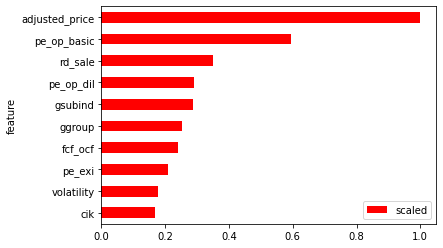

In [65]:
ef[['feature','scaled']].iloc[:10].set_index('feature').sort_values(by='scaled', ascending=True).plot(kind='barh',color='r') #.to_csv('features.csv') #plot.bar(rot=90)

<AxesSubplot:ylabel='feature'>

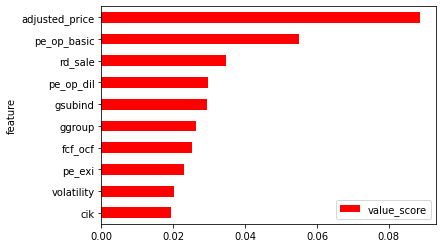

In [66]:
ef[['feature','value_score']].iloc[:10].set_index('feature').sort_values(by='value_score', ascending=True).plot(kind='barh',color='r')

In [86]:
# ef1 = ef.copy()[['feature','value_score']]
# ef1.loc[11]['value_score'] = ef1[['value_score']].iloc[10:].sum()
# ef1

In [20]:
# set up the ability to write images

importlib.reload(s3c)
s3f1 = s3c.s3finance(AWS_BUCKET)

def write_image(image_name):
    if not OUTPUT_DATA:
        return
    image =	BytesIO()
    plt.savefig(image, format='png', facecolor='white')
    image.seek(0)
    s3f1.putimagedata(image,image_name)

## Output all individual SHAP charts

In [ ]:
# output charts for evaluation for each model 
# 
def binary_performances(y_true, y_prob, thresh=0.5, labels=['Positives','Negatives'],image_name="precision_data"):
    
    shape = y_prob.shape
    if len(shape) > 1:
        if shape[1] > 2:
            raise ValueError('A binary class problem is required')
        else:
            y_prob = y_prob[:,1]
    
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y_true, (y_prob>thresh).astype(int))
    
    fig = plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                     annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
               'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title(f'Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    plt.subplot(132)
    plt.hist(y_prob[y_true==1], density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(y_prob[y_true==0], density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(thresh, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='orange',
             lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)


    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    results = {
        "Precision": precision, "Recall": recall,
        "F1 Score": F1, "AUC": roc_auc
    }
    
    prints = [f"{kpi}: {round(score, 3)}" for kpi,score in results.items()]
    prints = ' | '.join(prints)
    text = fig.text(3.5, 2.5,prints,horizontalalignment='center', wrap=True ) 
    write_image(image_name)
    plt.show()
    #print(prints)
    
    return results

def AUC(y_true, y_hat):
    return 'auc', roc_auc_score(y_true, y_hat), True

In [22]:

# print out shap analysis and other items
def outputshapimages(loaded_models):
    for i in range(len(loaded_models)):
        break
        model,Xt,yt,test_set = loaded_models[i]
        shap_values = shaplist[i]
        print(results.iloc[i]['date'])
        binary_performances(yt, model.predict_proba(Xt),thresh=0.5,image_name=f"precision_matrix_data_{results.iloc[i]['date']}.png") # thresh = 0.5)
        shap.plots.bar(shap_values,max_display=20, show=False)
        write_image(f"shap_bar_plot_{results.iloc[i]['date']}.png")
        plt.show()
        shap.summary_plot(shap_values,Xt[:250],max_display=20,show=False)
        write_image(f"shap_summary_plot_{results.iloc[i]['date']}.png")
        plt.show()
        #shap.summary_plot(shap_values,Xt,max_display=10)
#
if OUTPUT_DATA:
    outputshapimages(loaded_models)

In [23]:

all_ratios['monthly_date'] = pd.to_datetime(all_ratios['monthly_date'])
spyprices['datadate'] = pd.to_datetime(spyprices['datadate'])
all_prices['datadate'] = pd.to_datetime(all_prices['datadate'])

### Produce all charts and analysis

In [24]:
## Produce charts for all the individual stock pick periods as well as a summary graph which incorporates all the 
# performance attributes for this chart.
#

def drawallstockinfo(spyprices,all_ratios,all_prices,models, results, step=1, min_price=5, 
                     market_cap=300,model_start_date='2009-01-01',model_end_date='2022-02-01', 
                     numstocks=5,show_all_stocks=True,months=None, cumloss= None,periodinvestment=100,
                     holdperiod=12, remove_graph_legend=False):
    totalreturn = []
    sandpreturn = []
    modelist = models.copy()
    fullreturn = None
    sandpfullreturn = None
    stockpicks = pd.DataFrame(data=[], columns = ['top_pick','start_date','end_date','probability','model_accuracy'])
    min_sandp_date = None
    max_sandp_date = None
    outperform = 0
    actual_months = 0
    capitalatrisk = periodinvestment*holdperiod
    sapcapitalatrisk = periodinvestment*holdperiod
    totaldollars_available_stocks = periodinvestment*holdperiod
    totaldollars_available_andp = periodinvestment*holdperiod
    unique_id=0
  
    if months is None:
        months = len(models)
    
    # lastresult = results[-1]
    lastmodel = models[-1]
    
    # months exceed models available, we will fill down on the models
    #
    if months > len(models):
        for i in range(len(models),months):
            # results.append(lastresult)
            models.append(lastmodel)
    
    # look over all possible months and that we are considering
    for i,m in zip(range(len(models)),range(months)):
        start_date = (pd.to_datetime(min(models[i][3]['monthly_date']))+ relativedelta(months=1))#.strftime("%Y-%m-%d")
        end_date = (pd.to_datetime(start_date) + relativedelta(years=1))#.strftime("%Y-%m-%d")

        if start_date < pd.Timestamp(model_start_date) or end_date > pd.Timestamp(model_end_date):
            continue
        if min_sandp_date is None:
            min_sandp_date = start_date
            
        if min_sandp_date > start_date:
            min_sandp_date = start_date
            
        if max_sandp_date is None:
            max_sandp_date = end_date
        
        if max_sandp_date < end_date:
            max_sandp_date = end_date

        p = (start_date + relativedelta(months=step))

        predict_set=all_ratios[(all_ratios['monthly_date'] >= p) & 
                                (all_ratios['monthly_date'] < (p+ relativedelta(months=step))) 
                                & (all_ratios['prccd'] >= min_price) & (all_ratios['market_cap'] >= market_cap)]

        predict_set = predict_set[list(models[i][1].columns)]
        #print(p, (p+ relativedelta(months=step)), i, len(predict_set))
        #print('before estimation')
        p = models[i][0].predict_proba(predict_set)
        #print('after estimation')
        m = predict_set.copy()

        if len(p) == 0:
            continue
        m['probability'] = p[:,1]
        s = spyprices[(spyprices.datadate >= start_date) &  (spyprices.datadate < end_date)].copy()
        s['adjusted_price'] =s['prccd']/s['ajexdi']
        s1 = s['adjusted_price']
        s[f'SandP_Average_{i}'] = s1.pct_change() #(s1-s1.iloc[0])/(s1.iloc[0])

        s['SandP'] = (1 + s[f'SandP_Average_{i}']).cumprod() - 1
        s[f'SandP_Cum_{i}'] = s['SandP']
    
        if sandpfullreturn is None:
            #s[f'SandP_{i}'] = s['SandP']
            sandpfullreturn = s[['datadate',f'SandP_Cum_{i}',f'SandP_Average_{i}']].set_index('datadate').copy()
        else:
            #s[f'SandP_{i}'] = s['SandP']
            sandpfullreturn = pd.concat([sandpfullreturn, s[['datadate',f'SandP_Cum_{i}',f'SandP_Average_{i}']].set_index('datadate').copy()], axis=1)

        if show_all_stocks:  
            s['datadate'] = pd.to_datetime(s['datadate'])
            ax = (s[['SandP','datadate']].set_index('datadate').fillna(0)*100).plot(figsize=(15, 10),legend=True,style=['rs-'],markevery=[0,-1],marker='o', ms=10)

        alltickers = (all_ratios.iloc[m.sort_values(by='probability', ascending=False).index])[['ticker','cusip','gvkey']]
        alltickers['probability'] = m.sort_values(by='probability', ascending=False)['probability']
        count = 0
        cell_text = []
        rows = []
        percents=0

        modelreturn = None
        modelscore = models[i][0].best_score_ #results.iloc[i]['score']
        usedtickers = []
        actual_months += 1
        for c, (index,ticker) in zip(range(numstocks*100),alltickers.iterrows()):
            if ticker['ticker'] in usedtickers:
                continue
            usedtickers.append(ticker['ticker'])
            #print(usedtickers)
            prices = all_prices[(all_prices.tic == ticker['ticker'])].copy() #(all_prices.tic == ticker['ticker'])
            #prices = all_prices[(all_prices.cusip == ticker['cusip'])].copy()

            if prices is None or len(prices) <= 1:# or prices.isnull().values.any(): # or min(prices['prccd']) <10:
                if prices is None:
                    m = None
                else:
                    m = len(prices['prccd'])    
                #print(f"Could not find stock {ticker['ticker']}, {ticker['cusip']},{ticker['gvkey']} min: {m}")
                continue

            prices = prices[(prices.datadate >= start_date) &  (prices.datadate < end_date)]
            prices = prices[['adjusted_price','datadate']].drop_duplicates(subset=['datadate'],keep='last')

            res = len(nyse.valid_days(start_date=start_date.strftime('%Y-%m-%d'), end_date=end_date.strftime('%Y-%m-%d')))

            if len(prices) == 0:# or abs(len(prices) - res) > 2:
                #print(f"No price data for stock {ticker['ticker']}, {ticker['gvkey']}, {len(prices)}")
                continue
            stockpicks = stockpicks.append({'top_pick' : ticker['ticker'],
                                            'start_date' : start_date,
                                            'end_date' : end_date,
                                            'probability' : ticker['probability'],
                                            'model_accuracy' : modelscore} , ignore_index=True)            
            nprice = str(ticker['ticker'])+ f"_{ticker['probability']:.2f}__{unique_id}"
            unique_id += 1

            prccd = prices['adjusted_price'] #'prccd'
            #print(f'percent change for {nprice} = {(prccd.iloc[-1]-prccd.iloc[0])/prccd.iloc[0]}')
            prices[nprice] = prccd.pct_change()
            if modelreturn is None:
                modelreturn = prices[[nprice,'datadate']].set_index('datadate').copy()
            else:
                modelreturn = pd.concat([modelreturn, prices[[nprice,'datadate']].set_index('datadate').copy()], axis=1)
            prices[nprice] = (1 + prices[nprice]).cumprod() - 1

            gain = (prices[nprice].iloc[-1])*100.0

            cell_text.append([ticker['ticker'],f"{ticker['probability']:.2f}",f"{gain:.2f}%"])
            p = prices.copy()
            p['datadate'] = pd.to_datetime(p['datadate'])
            if show_all_stocks:
                ax = (p[[nprice,'datadate']].set_index('datadate').fillna(0)*100).plot(ax=ax,markevery=[0,-1],marker='o', ms=10)

            count += 1
            rows.append(str(count))
            if count >= numstocks:
                break

        modelreturn[f'Average_{i}'] = modelreturn.mean(axis=1) #((1+modelreturn).cumprod()-1).mean(axis=1)
        modelreturn[f'Cumaverage_{i}'] =  ((1+modelreturn[f'Average_{i}']).cumprod()-1)
        if fullreturn is None:
            fullreturn = modelreturn.copy()
        else:
            fullreturn = pd.concat([fullreturn, modelreturn.copy()], axis=1)
        
        avgreturn = modelreturn[f'Cumaverage_{i}']
        if avgreturn.iloc[-1] < 0.0:
            capitalatrisk += (-avgreturn.iloc[-1] * periodinvestment)
        if s['SandP'].iloc[-1] < 0.0:
            sapcapitalatrisk += (-s['SandP'].iloc[-1] * periodinvestment)
            
        if avgreturn.iloc[-1] > s['SandP'].iloc[-1]:
            outperform += 1
            
        cell_text.append(["Average Return","",f"{avgreturn.iloc[-1]*100:.2f}%"])
        cell_text.append(['SPY',"1.0", f"{(s['SandP'].iloc[-1]*100):.2f}%"])
        rows.append(str(count))
        rows.append(str(count+1))
        if not show_all_stocks:
            continue
        labelLines(ax.get_lines(),  align=False,  color="k") # 
        ax.legend(loc='upper left')
        #plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        columns = ('Stock Name', 'Probability Of Outperforming', 'Actual Percentage Performance')
        # Add a table at the bottom of the axes
        the_table = ax.table(cellText=cell_text,rowLabels=rows,  colLabels=columns, loc='bottom', bbox=[0.0,-0.4,0.6,.28]) #rowColours=colors,
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(10)

        plt.xlabel("Investment Dates")
        plt.ylabel("Percent Return")
        plt.show()

    
    f = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
    ax = f.gca()
    ax = plt.subplot(gs[0])
    
    ffullavg = fullreturn.loc[:, fullreturn.columns.str.contains('Cumaverage_')]
    ffullavg = ffullavg.ffill(axis=0).mean(axis=1)#.sum(axis=1)
    ffullret = fullreturn.loc[:, fullreturn.columns.str.contains('Cumaverage_')]#fullreturn.columns.str.contains('Average_')]
    ffullret = ffullret.ffill(axis=0).sum(axis=1)#.sum(axis=1)
    #print(fullreturn.to_string(), ffullavg)

    fullreturn['Stocks Average Return'] = ffullavg
    fullreturn['Stocks Total Return'] = ffullret#.cumsum()#*periodinvestment
    #print(fullreturn.to_string())

    (fullreturn[['Stocks Average Return']].fillna(0)*100).plot(ax=ax,markevery=[0,-1],marker='o', style=['k-'],ms=10)
    
    sapffull = sandpfullreturn.loc[:, sandpfullreturn.columns.str.contains('SandP_Cum_')]
    sapffullavg = sapffull.ffill(axis=0).mean(axis=1)#.sum(axis=1)
    sapffullsum = sapffull.ffill(axis=0).sum(axis=1)
    
    #print(sandpfullreturn.to_string(), sapffullavg)
    #sandpfullreturn = sandpfullreturn.ffill(axis=0)
    #print(sandpfullreturn.columns)
    sandpfullreturn['S and P Average Return'] = sapffullavg #((1+sapffullavg).cumprod()-1) #sandpfullreturn.sum(axis=1)
    sandpfullreturn['S and P Total Return'] = sapffullsum#*periodinvestment
    #print(sandpfullreturn.to_string())
    #sandpfullreturn = sandpfullreturn[['S and P Average Return','S and P Total Return']]
    (sandpfullreturn[['S and P Average Return']].fillna(0)*100).plot(ax=ax,markevery=[0,-1],marker='o', style=['rs-'],ms=10)

    ax.set_xlabel("Investment Dates")
    ax.set_ylabel("Percent Return")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2 = plt.subplot(gs[1], sharex = ax)
    #ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    style = ['b-']
    style = ['g-']
    stylestocks = ['k-']
    stylesandp = ['r-']
    (fullreturn[['Stocks Total Return']].fillna(0)*100).plot(ax=ax2,markevery=[0,-1],marker='o', style=stylestocks,ms=10)
    (sandpfullreturn[['S and P Total Return']].fillna(0)*100).plot(ax=ax2,markevery=[0,-1],marker='o', style=stylesandp,ms=10)
    ax2.set_ylabel("Total Return")#"gdpPercap",color="blue",fontsize=14)
    #plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),ncol=3)
    ax.legend(loc='upper left')#, bbox_to_anchor=(1.0, 0.5),ncol=3)
    ax2.legend(loc='upper right')#, bbox_to_anchor=(1.0, 0.5),ncol=3)
    begin_date = fullreturn.index[0]
    end_date = fullreturn.index[-1]
    # print(begin_date,end_date)
    ax.set_xlim(begin_date,end_date)
    ax.margins(x=0)
    ax.tick_params(which='minor', length=1, color='r')
    rng = pd.date_range(begin_date,end_date + pd.offsets.MonthEnd(), freq='1M')
    
    ax.set_xticks(rng)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.set_xlabel("Investment Dates")   
    ax2.set_xlabel("Investment Dates")
    # ax2.set_xlim(begin_date,end_date)
    
    if remove_graph_legend:
        ax.get_legend().remove()
        ax2.get_legend().remove()

    plt.subplots_adjust(hspace=.0)
    write_image(f'total_return_image_{modelname}_{numstocks}_{months}_{model_start_date}_{model_end_date}_{min_price}_{market_cap}')
    plt.show()
    
    #actual_months = min(months,len(models))
    print(f"Total # of Stocks: {numstocks}, Total # of months: {actual_months}, Percentage Models Outperform: {outperform/actual_months*100:.2f}%")
    averagereturn = fullreturn['Stocks Average Return'].iloc[-1]
    sapaveragereturn = sandpfullreturn['S and P Average Return'].iloc[-1]
    #print(excessreturn,sapexcessreturn)
    totalinvestment = periodinvestment * actual_months
    totalreturn = fullreturn['Stocks Total Return'].iloc[-1]*periodinvestment#((periodinvestment * holdperiod) * ((1 +  averagereturn) ** (actual_months/holdperiod))
    saptotalreturn = sandpfullreturn['S and P Total Return'].iloc[-1]*periodinvestment #((periodinvestment * holdperiod) * (1 + sapaveragereturn)) ** (actual_months/holdperiod)
    investmentmonths = actual_months#-1+holdperiod
    annualreturn = ((totalreturn/totalinvestment)**(12/investmentmonths))-1
    sapannualreturn = ((saptotalreturn/totalinvestment)**(12/investmentmonths))-1
    print(f"Average Percentage Return: {averagereturn*100:.2f}%")
    print(f"S&P Average Percentage Return: {sapaveragereturn*100:.2f}%")
    print(f"Period Investment: {periodinvestment}")
    print(f"Max Capital at Risk: ${capitalatrisk:.2f} : Return After {investmentmonths} months: ${totalreturn:.2f}")
    print(f"S&P Max Capital at Risk: ${sapcapitalatrisk:.2f} Return After {investmentmonths} months: ${saptotalreturn:.2f}")
    #fullreturn = fullreturn.loc[:, ~fullreturn.columns.str.contains('Average_')]
    # write out the combined data for homepage
    outputhomepage = fullreturn.merge(sandpfullreturn, left_on='datadate', right_on='datadate')
    return outputhomepage,stockpicks

In [25]:
print(len(loaded_models))

214


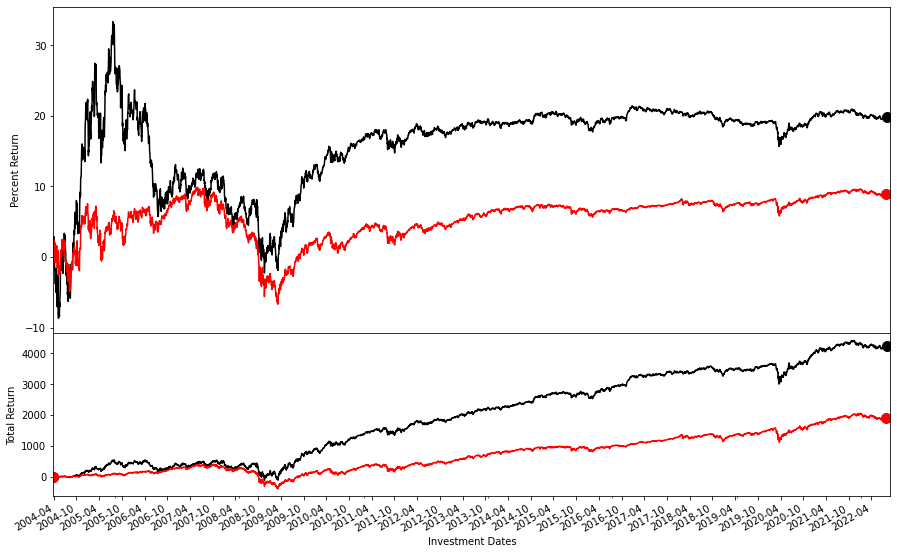

Total # of Stocks: 5, Total # of months: 213, Percentage Models Outperform: 68.08%
Average Percentage Return: 19.85%
S&P Average Percentage Return: 8.88%
Period Investment: 100
Max Capital at Risk: $2078.17 : Return After 213 months: $4227.81
S&P Max Capital at Risk: $1796.47 Return After 213 months: $1891.39
CPU times: user 32min 38s, sys: 8.2 s, total: 32min 47s
Wall time: 32min 41s


In [26]:
%%time
# generate stock charts and stock picks
allstockspage, stockpicks = drawallstockinfo(spyprices,all_ratios,all_prices,loaded_models,results,numstocks=5,
                                             show_all_stocks=False,months=214,model_start_date='1990-01-01',
#                                             model_end_date='2005-04-01',
                                             model_end_date='2023-05-01',
                                             min_price=5, market_cap=300,
                                             periodinvestment=100,holdperiod=12,
                                            remove_graph_legend=True)


In [28]:
%%capture
# Output all chart data for the website to S3

if OUTPUT_DATA:
    s3f.putmonthlyavgchart(allstockspage)
    s3f.puttoppickstable(stockpicks)
    s3f.putmainpagechart(allstockspage)

allstockspage
s3f.currentversion

## This section is work in progress to get the Sharpe Ratio for all the stock performances and analysis
#

In [ ]:
breakexecutionhere

In [ ]:
# set up risk free rate
# get the risk free rate
s3f1 = s3c.s3finance(AWS_BUCKET)
rfr = s3f1.getbasefile('riskfreerate')
rfr.columns
#str(rfr.mcaldt[rfr.tmytm==rfr['tmytm'].min()].iloc[0]),rfr['tmytm'].min(),str(rfr.mcaldt[rfr.tmytm==rfr['tmytm'].max()].iloc[0]),rfr['tmytm'].max()
rfrmodified = rfr[rfr['kytreasnox'] == rfr['kytreasnox'].unique()[0]]

start_date = rfrmodified.mcaldt.min() + pd.DateOffset(day=1)
end_date = rfrmodified.mcaldt.max() + pd.DateOffset(day=31)
print(start_date,end_date)
dates = nyse.valid_days(start_date=start_date.strftime('%Y-%m-%d'), 
                        end_date=end_date.strftime('%Y-%m-%d')).tz_localize(None)
dates.name = 'datadate'
rfrmodified = rfrmodified.rename(columns={'mcaldt': 'datadate'}).set_index('datadate')[['tmytm']]
rfrmodified = rfrmodified.reindex(dates,method='ffill').dropna()
#rfrmodified.head(100)

In [ ]:
(len(allstockspage.loc[:, allstockspage.columns.str.contains('Average_')].columns)-120)/120

(len(allstockspage.loc[:, allstockspage.columns.str.contains('Cumaverage_')].columns))

In [ ]:
allstockspage1 = allstockspage
stockpicks1 = stockpicks

In [ ]:
len(allstockspage1),len(stockpicks1)

In [ ]:
len(all_prices)

In [ ]:
allstockspage.loc[:, allstockspage.columns.str.contains('Cumaverage_')].columns

In [ ]:
averagestocks =  allstockspage.loc[:, (allstockspage.columns.str.contains('Cumaverage_'))]
averagestocks = averagestocks.loc[:, ~averagestocks.columns.str.contains('SandP_Average_')]
averagestocks.columns

In [ ]:
start_range=0
end_range=len(averagestocks.columns) #214
return_window=108
return_columns = [[f'Cumaverage_{j}' for j in range(i, i+return_window)] for i in range(start_range,end_range-return_window)]
#allstockspage.loc[:, allstockspage.columns.str.contains('Total Return')]
return_columns[0]

In [ ]:

for r in range(len(return_columns)):
    out=averagestocks.loc[:, averagestocks.columns.isin(return_columns[r])].apply(pd.Series.last_valid_index)
    print(out.values)
    totalreturn=0
    for i in range(108):
        #print(averagestocks.loc[out.values[i]],averagestocks.loc[out.values[r]][i])
        totalreturn += averagestocks.loc[out.values[r]][i]
    print(totalreturn)
#print(type(out))

In [ ]:
total_return = 0
for i in range(10):
    total_return += averagestocks.loc[:, averagestocks.columns.isin([return_columns[0]])].dropna(how='all').sum(axis=1).iloc[-1]
print(total_return)
#(averagestocks.loc[:, averagestocks.columns.isin(return_columns[2])].dropna(how='all').sum(axis=1)+1).cumprod()-1

In [ ]:
(averagestocks.loc[:, averagestocks.columns.isin(return_columns[0])].dropna(how='all').sum(axis=1) +1).cumprod()-1

In [ ]:
rfrmodified['daily_return'] = (((rfrmodified['tmytm']/100)+1)**(1/365))-1

In [ ]:
daily_return=allstockspage.loc[:, allstockspage.columns.isin(return_columns[0])].sum(axis=1)
portfolio_return = (daily_return - rfrmodified['daily_return']).dropna()
sharpe_ratio = portfolio_return.mean()/portfolio_return.std()
sharpe_ratio

In [ ]:
daily_return

In [ ]:
rfrmodified/100

In [ ]:
(daily_return - rfrmodified['tmytm']/100).dropna()

In [ ]:

f = plt.figure(figsize=(20, 10))
ax = f.gca()
alls = allstockspage.fillna(0)
# averagereturn = fullreturn['Stocks Average Return'].iloc[-1]
#     sapaveragereturn = sandpfullreturn['S and P Average Return'].iloc[-1]
(alls.loc[:, ['S and P Average Return']]*100).plot(ax=ax,markevery=[0,-1],marker='o', style=['r-'],ms=10)
(alls.loc[:, ['Stocks Average Return']]*100).plot(ax=ax,markevery=[0,-1],marker='o', style=['k-'],ms=10)
#((alls['Stocks Average Return']-alls['S and P Average Return'])*100).plot(ax=ax,markevery=[0,-1],marker='o', style=['b-'],ms=10)
avgreturn=(alls['Stocks Average Return']-alls['S and P Average Return']).mean()*100
ax.hlines(y=avgreturn,xmin=alls.reset_index()['datadate'].min(),xmax=alls.reset_index()['datadate'].max(),color='g',label='Above S&P Return')
ax.set_xlabel("Investment Dates")
ax.set_ylabel("Percent Return")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax2=ax.twinx()
(alls.loc[:, alls.columns.str.contains('Total Return')]*100).plot(ax=ax2,markevery=[0,-1],marker='o', style=['o-'],ms=10,label='Return Difference')
#alls.plot(ax=ax,markevery=[0,-1],marker='o', style=['k-'],ms=10)
ax2.set_ylabel("Total Dollar Return")
ax.legend(loc='upper left')#, bbox_to_anchor=(1.0, 0.5),ncol=3)
ax2.legend(loc='upper right')#, bbox_to_anchor=(1.0, 0.5),ncol=3)
plt.show()
print('Average excess return',avgreturn,'\nAverage return: ', 
      (alls['Stocks Average Return'].mean())*100, '\nAverage S&P return: ', 
      (alls['S and P Average Return'].mean())*100)

In [ ]:
list(allstockspage.loc[:, allstockspage.columns.str.contains('Cumaverage_')])

In [ ]:
a = allstockspage.fillna(0).reset_index()
d = list(set(a['datadate'].apply(lambda x: pd.to_datetime(f'{x.year}/01/01'))))
d.sort()
d = d + [d[-1] + relativedelta(years=1)]
s = d[0]
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),ncol=3)
for e in d[1:]:
    p = a[(a['datadate'] >= s) & (a['datadate'] < e)].set_index(['datadate'])
    p = p #- p.iloc[0]
    (p[['Stocks Average Return','S and P Average Return']]*100).plot(rot=90)
    s = e
# alls.plot(ax=ax,markevery=[0,-1],marker='o', style=['k-'],ms=10)
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),ncol=3)
# for i in range(len(d)
#                interval

In [ ]:
# s3f = s3c.s3finance(AWS_BUCKET)
# stockidsconsolidated = s3f.getbasefile('stockidsconsolidatedcompany')
# stockidsconsolidated.iloc[:10]


In [ ]:
# #stockpicks['top_pick'][stockpicks['top_pick'].isin(stockidsconsolidated['ticker'])]
# for i in range(len(stockpicks)):
#     pick = "\'" + stockpicks.iloc[i]['top_pick'] + "\'"
#     stockpicks.at[i,'full_name'] = stockidsconsolidated['conml'][stockidsconsolidated['ticker'].str.contains(pick)].iloc[0]

# stockpicks['probability'].mean(),stockpicks['model_accuracy'].mean()

In [ ]:
# stockpicks.iloc[:10]

In [ ]:
# a = alls.copy()
# print( a.filter(regex='^[A-Z]*_0\.[0-9]+__\.*').columns)
# #a['conml'] = stockidsconsolidated['conml'][a['gvkey']==stockidsconsolidated['gvkey']]